<a href="https://colab.research.google.com/github/Blvisse/Breast-Cancer-Causality/blob/EDA/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dowhy

     |████████████████████████████████| 123 kB 4.7 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
import dowhy
import pandas as pd
import numpy as np
import seaborn as sns
from dowhy import CausalModel


data=pd.read_csv('/content/final_data.csv')


In [ ]:
data

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,20.57,17.77,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,0,19.69,21.25,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,0,20.29,14.34,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
3,0,12.45,15.70,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
4,0,18.25,19.98,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1,14.05,27.15,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321
491,0,20.92,25.09,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.0260,0.006399,0.04310,0.07845,0.02624,0.02057,0.006213,24.29,29.41,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
492,0,21.56,22.39,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.40,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
493,0,20.13,28.25,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.69,38.25,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637


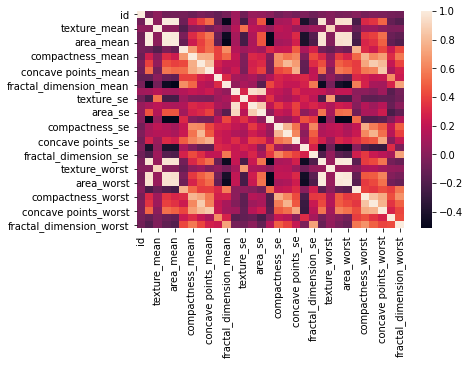

In [ ]:
sns.heatmap(data.corr())

In [ ]:
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,0.2699,0.7886,2.058,23.56,0.008462,0.014600,0.02387,0.013150,0.01980,0.002300,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
1,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,0.1852,0.7477,1.383,14.67,0.004097,0.018980,0.01698,0.006490,0.01678,0.002425,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
2,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.70,0.009606,0.014320,0.01985,0.014210,0.02027,0.002968,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
3,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,0.1839,2.3420,1.170,14.16,0.004352,0.004899,0.01343,0.011640,0.02671,0.001777,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
4,855167,M,13.440,21.58,86.18,563.0,0.08162,0.06031,0.03110,0.02031,0.1784,0.05587,0.2385,0.8265,1.572,20.53,0.003280,0.011020,0.01390,0.006881,0.01380,0.001286,15.930,30.25,102.50,787.9,0.10940,0.20430,0.20850,0.11120,0.2994,0.07146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,923748,B,10.860,21.48,68.51,360.5,0.07431,0.04227,0.00000,0.00000,0.1661,0.05948,0.3163,1.3040,2.115,20.67,0.009579,0.011040,0.00000,0.000000,0.03004,0.002228,11.660,24.77,74.08,412.3,0.10010,0.07348,0.00000,0.00000,0.2458,0.06592
243,923780,B,11.130,22.44,71.49,378.4,0.09566,0.08194,0.04824,0.02257,0.2030,0.06552,0.2800,1.4670,1.994,17.85,0.003495,0.030510,0.03445,0.010240,0.02912,0.004723,12.020,28.26,77.80,436.6,0.10870,0.17820,0.15640,0.06413,0.3169,0.08032
244,924632,B,12.880,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,0.05708,0.2116,1.3600,1.502,16.83,0.008412,0.021530,0.03898,0.007620,0.01695,0.002801,13.890,35.74,88.84,595.7,0.12270,0.16200,0.24390,0.06493,0.2372,0.07242
245,925292,B,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,2.888,29.84,0.007256,0.026780,0.02071,0.016260,0.02080,0.005304,15.300,33.17,100.20,706.7,0.12410,0.22640,0.13260,0.10480,0.2250,0.08321


In [ ]:
model=CausalModel(
        data = data,
        treatment='radius_mean',
        outcome='diagnosis',
        
        )

WARN: Are you sure that there are no common causes of treatment and outcome? [y/n] y


In [ ]:
identified_estimand=model.identify_effect()

AttributeError: ignored

In [ ]:
!pip install causalgraphicalmodels

In [ ]:
from causalgraphicalmodels import CausalGraphicalModel

In [ ]:
effect=CausalGraphicalModel(nodes=data.columns,edges=[
          ("radius_mean","diagnosis"),
          ("texture_mean","diagnosis"),
          ("smoothness_mean","diagnosis"),
          ("smoothness_mean","radius_mean"),
          ("compactness_mean","diagnosis"),
          ("concavity_mean","diagnosis"),
          ("concave points_mean","diagnosis"),
          ("symmetry_mean","diagnosis"),
          ("fractal_dimesnion_mean","diagnosis"),
          ("radius_worst","diagnosis"),
          ("texture_worst","diagnosis"),
          ("smoothness_worst","diagnosis"),
          ("smoothness_worst","radius_worst"),
          ("compactness_worst","diagnosis"),
          ("concavity_worst","diagnosis"),
          ("concave points_worst","diagnosis"),
          ("symmetry_worst","diagnosis"),
          ("fractal_dimesnion_worst","diagnosis"),
          ("radius_se","diagnosis"),
          ("texture_se","diagnosis"),
          ("smoothness_se","diagnosis"),
          ("smoothness_se","radius_se"),
          ("compactness_se","diagnosis"),
          ("concavity_se","diagnosis"),
          ("concave points_se","diagnosis"),
          ("symmetry_se","diagnosis"),
          ("fractal_dimesnion_se","diagnosis"),
          ("compactness_se","diagnosis"),
          ("fractal_dimesnion_se","diagnosis"),
          ("perimeter_se","diagnosis")
                                            
        ])

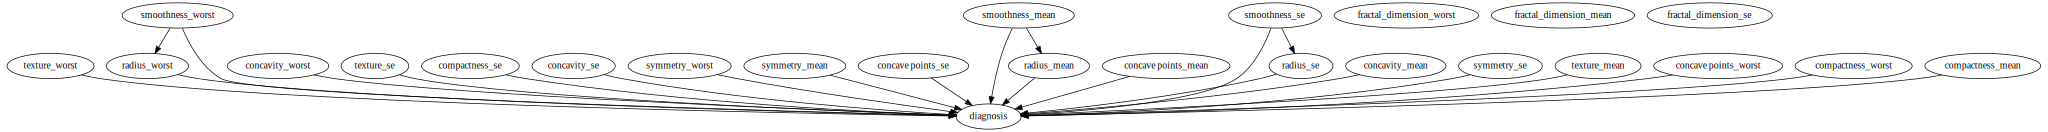

In [ ]:
effect.draw()

In [ ]:
print(effect.get_distribution())

P(texture_mean)P(smoothness_mean)P(compactness_mean)P(concavity_mean)P(concave points_mean)P(symmetry_mean)P(fractal_dimension_mean)P(texture_se)P(smoothness_se)P(compactness_se)P(concavity_se)P(concave points_se)P(symmetry_se)P(fractal_dimension_se)P(texture_worst)P(smoothness_worst)P(compactness_worst)P(concavity_worst)P(concave points_worst)P(symmetry_worst)P(fractal_dimension_worst)P(fractal_dimesnion_mean)P(fractal_dimesnion_worst)P(fractal_dimesnion_se)P(perimeter_se)P(radius_mean|smoothness_mean)P(radius_se|smoothness_se)P(radius_worst|smoothness_worst)P(diagnosis|radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimesnion_mean,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimesnion_worst,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimesnion_se,perimeter_se)


In [ ]:
effect.get_all_independence_relationships()

In [ ]:
model=CausalModel(
        data = data,
        treatment='radius_worst',
        outcome='diagnosis',
        
        )

WARN: Are you sure that there are no common causes of treatment and outcome? [y/n] y


In [ ]:
identified_estimand = model.identify_effect()

AttributeError: ignored